In [263]:
import numpy as np
import cv2
import pydrake
import matplotlib.pyplot as plt
%matplotlib notebook

In [203]:
# run cassie_joy_env, or similar script, and collect some images and states (need to save the full base state)
# step_images = np.load("step_images.npy")
# states = np.load("step_states.npy")

# step_images = np.load("step_images_obst.npy")
# states = np.load("step_states_obst.npy")
step_images = np.load("ref_images.npy")
states = np.load("ref_states.npy")

In [204]:
im0 = step_images[0]

In [205]:
im0 = im0.astype(np.float32)
im0 = im0/2**16

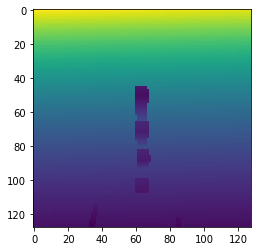

In [206]:
# remember that colors are scaled here
idx = 40
plt.imshow(step_images[idx].astype(np.float32)/2**16)

In [207]:
print(step_images[idx][100:110,20:30])

[[714 714 714 714 714 714 714 714 714 714]
 [711 711 711 711 710 710 710 710 710 710]
 [707 707 707 707 707 707 707 707 707 707]
 [704 704 704 704 704 703 703 703 703 703]
 [700 700 700 700 700 700 700 700 700 700]
 [697 697 697 697 697 697 697 697 696 696]
 [694 694 694 693 693 693 693 693 693 693]
 [690 690 690 690 690 690 690 690 690 690]
 [687 687 687 687 687 687 687 687 687 686]
 [684 684 684 684 684 683 683 683 683 683]]


In [208]:
ddepth = cv2.CV_16S
sob_x = cv2.Sobel(step_images[idx], ddepth, 1, 0, ksize=7)
sob_y = cv2.Sobel(step_images[idx], ddepth, 0, 1, ksize=7)
sob = 0.5 * sob_x + 0.5 * sob_y

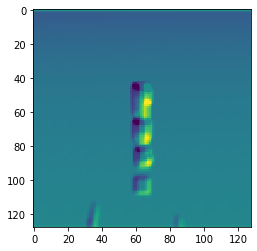

In [209]:
plt.imshow(sob)

In [81]:
pos_names = ['base_qw', 'base_qx', 'base_qy', 
             'base_qz', 'base_x', 'base_y', 'base_z', 
             'hip_roll_left', 'hip_roll_right', 'hip_yaw_left', 
             'hip_yaw_right', 'hip_pitch_left', 'hip_pitch_right', 
             'knee_left', 'knee_right', 'knee_joint_left', 
             'knee_joint_right', 'ankle_joint_left', 'ankle_joint_right', 
             'ankle_spring_joint_left', 'toe_left', 
             'ankle_spring_joint_right', 'toe_right']

-7104


In [ ]:
# Transform an image from pixel coords to world coordinates.
# get the pelvis -> world
# get camera frame -> pelvis
# get (pixel_x, pixel_y, value) -> camera frame

# want to avoid: high gradient regions (big sobel), points that are too "high up", points that are too far away...
# set padding to like 20 pixels...?

In [210]:
from pytransform3d import transformations as pt
from pytransform3d.rotations import active_matrix_from_extrinsic_roll_pitch_yaw

state [ 3.06636543e-04 -4.41221071e-04  7.50286117e-01]
world point in body frame:[ 0.80226471  0.00622894 -0.74751017  1.        ]
world point in camera frame:[-0.00562989 -0.3365939   0.89979567  1.        ]
p = [63.37431473 26.59218458  1.        ]


<IPython.core.display.Javascript object>


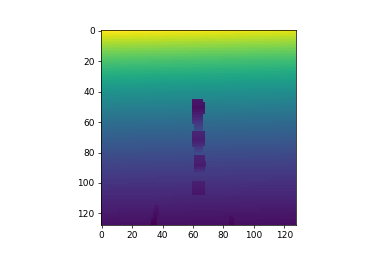

1.119
pixel coords mapped through inverse intrinsics:[-0.00700142 -0.41859345  1.119       1.        ]
pixel coords mapped to body frame: [ 0.98552819  0.00774641 -0.89307301  1.        ]
[ 9.82762853e-01  3.65795324e-04 -1.46198324e-01  1.00000000e+00]


In [481]:
data_idx = 40
state = states[data_idx]
orientation = state[0:4]
im = np.array(step_images[data_idx]/1000)
print(f"state {state[4:7]}")
# print(orientation)
c_x, c_y = 64, 64
f_x, f_y = 100, 100

K = np.array([[f_x, 0, c_x],
              [0, f_y, c_y],
              [0, 0, 1]])

b2w = transformations.transform_from_pq(np.hstack([state[4:7], orientation]))
camera_rot = active_matrix_from_extrinsic_roll_pitch_yaw([-2.6, 0.0, -1.57])
c2b = transformations.transform_from(camera_rot, [0.05, 0, -0.15])
# incorporate the sensor to camera transformation as well? slight x shift could cause observed disparity in image?
# s2c = transformations.transform_from_pq([0.015, -0.00019, -0.0001, 1, 0, 0, 0])
# b2c = transformations.concat(s2c, b2s)
b2c = pt.invert_transform(c2b)

p_w = [0.8, 0.00, 0.0, 1]

# this should be the world point expressed in body frame?
print(f"world point in body frame:{pt.transform(pt.invert_transform(b2w), p_w)}")
c2w = pt.concat(c2b, b2w)
w2c = pt.invert_transform(c2w)

p_c = transformations.transform(w2c, p_w)
print(f"world point in camera frame:{p_c}")

p = (K @ (p_c[0:3]/p_c[2]))
print(f"p = {p}")
# coords = (p[0:2]/p[2]).astype(int)
# im[coords[1], coords[0]] = 1
plt.figure()
plt.imshow(im)
# y coord in camera frame is rows, x coord is columns
row = p[1]
col = p[0]
print(im[int(row), int(col)])
p_c = np.array([(col - c_x) * float(im[int(row), int(col)]) * 1/f_x,
      (row - c_y) * float(im[int(row), int(col)]) * 1/f_y,
      float(im[int(row), int(col)]), 1])
# losses come from the intrinsics matrix

print(f"pixel coords mapped through inverse intrinsics:{p_c}")
p_cb = pt.transform(c2b, p_c)
print(f"pixel coords mapped to body frame: {p_cb}")
p_cb[0:3] = p_cb[0:3]
p_cw = pt.transform(b2w, p_cb)

print(p_cw/p_cw[3])

In [502]:
# Experiment with transforms to see where the losses are occurring
#p_b = [1, 1, -0.8, 1]
#p_w = pt.transform(b2w, p_b) 
#print(f"body point in world frame:{p_w}")
#print(f"converted back to body frame:{pt.transform(pt.invert_transform(b2w), p_w)}")
#print()
# I assume that going from world to camera and back will be fine.
p_w = [0.3, 0.0, 0.0, 1]
p_c = pt.transform(w2c, p_w)
print(f"world point in camera frame:{p_c}")
print(f"camera point in world frame:{pt.transform(c2w, p_c)}")
print(f"camera point in image:{K @ p_c[0:3]/p_c[2]}")
# seems like the losses are from the intrinsic matrix.
# p_im = [47, 63, im[50, 63]]
K = np.array([[f_x, 0, c_x],
              [0, f_y, c_y],
              [0, 0, 1]])

p_im = K @ (p_c[0:3]/p_c[2])
p_im2 = [p_im[0], p_im[1], im[int(p_im[0]), int(p_im[1])]]

# p_cf = np.linalg.inv(K) @ p_im
# p_c = p_cf

p_c = np.array([(p_im[0] - c_x) * float(p_im2[2]) * 1/f_x,
      (p_im[1] - c_y) * float(p_im2[2]) * 1/f_y,
      float(p_im2[2]), 1])
p_cf = [p_c[0], p_c[1], p_c[2], 1]
print(f"camera point in world frame:{pt.transform(c2w, p_cf)}")

world point in camera frame:[-0.00558438  0.09273473  0.64352058  1.        ]
camera point in world frame:[0.3 0.  0.  1. ]
camera point in image:[63.13221408 78.41053021  1.        ]
camera point in world frame:[ 3.87280723e-01  5.23777721e-04 -2.09339541e-01  1.00000000e+00]


<IPython.core.display.Javascript object>


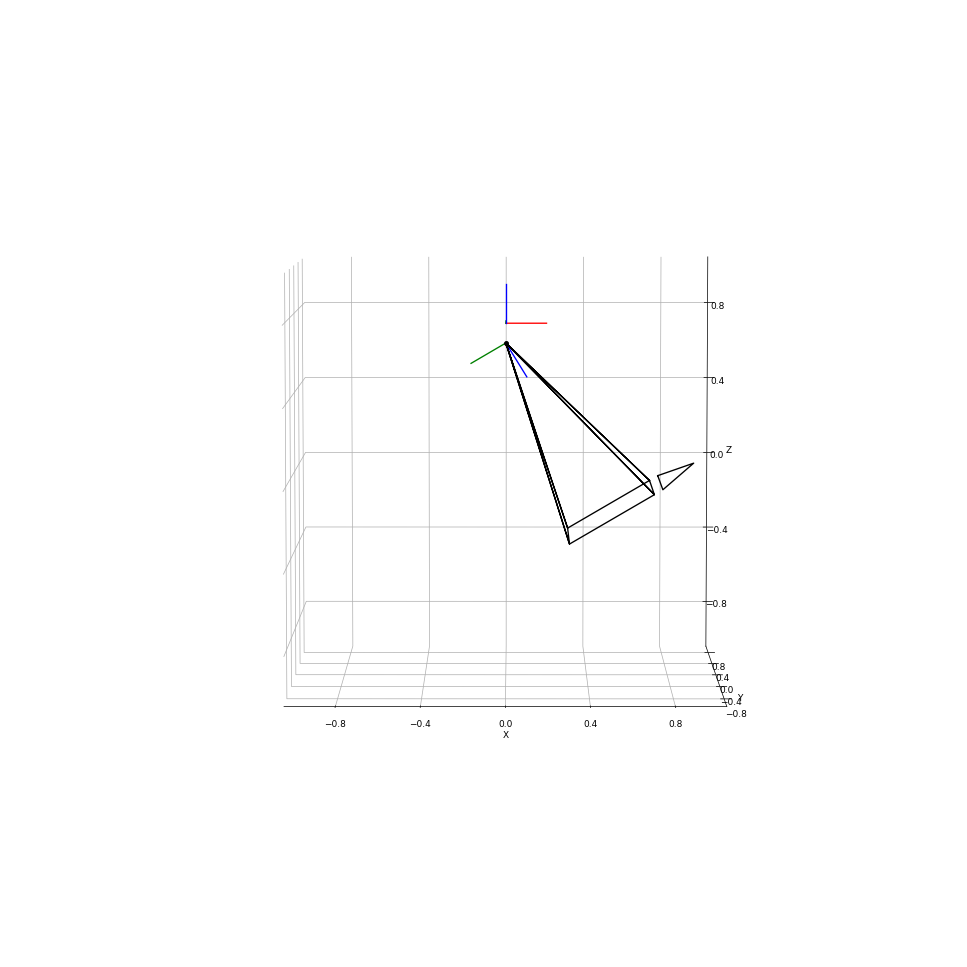

In [446]:
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
import pytransform3d.rotations as pr

plt.figure(figsize = (15, 15))
# default parameters of a camera in Blender
# default parameters of a camera in Blender
sensor_size = np.array([0.036, 0.024])
intrinsic_matrix = np.array([
    [0.05, 0, sensor_size[0] / 2.0],
    [0, 0.05, sensor_size[1] / 2.0],
    [0, 0, 1]
])
virtual_image_distance = 1

w2b = transformations.transform_from_pq(np.hstack([state[4:7], [1, 0, 0, 0]]))
initial_rot = active_matrix_from_extrinsic_roll_pitch_yaw([0, 0, -1.57])
identity = transformations.transform_from_pq([0, 0, 0, 1, 0, 0, 0])
camera_rot = active_matrix_from_extrinsic_roll_pitch_yaw([0, 2.6, 0.0])

c2c = transformations.transform_from(initial_rot, [0, 0, 0])

b2c = pt.concat(c2c, pt.transform_from(camera_rot, [0, 0, -0.1]))

ax = pt.plot_transform(A2B=w2b, s = 0.2)
pt.plot_transform(ax, transformations.concat(b2c, w2b), s = 0.2)

pc.plot_camera(
    ax, cam2world=transformations.concat(b2c, w2b), M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)
plt.show()

## testing functions for the final script